# Gaussian process regression for arterial tissue

In [34]:
import numpy as np
import GPy
from IPython.display import display
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error as mse
import math 
import pickle
import pandas as pd
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from warnings import catch_warnings
from warnings import simplefilter
from pyDOE import *
plt.style.use("seaborn-darkgrid")

<function matplotlib.pyplot.show(close=None, block=None)>

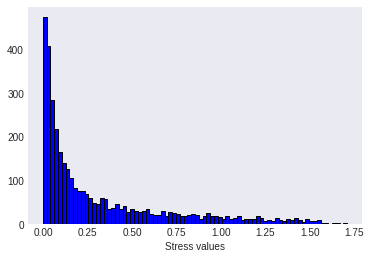

In [39]:
## The ground-truth data
strain_fe_adventitia = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35] 
stress_fe_adventitia = [0, 0.000967127, 0.00192, 0.00286563, 0.00381458, 0.00478288, 0.00579386, 0.00688035, 0.00808715, 0.00947402, 0.0111194, 0.013125, 0.0156211, 0.0187736, 0.0227912, 0.0279346, 0.0345266, 0.0429626, 0.053722, 0.0673801, 0.0846188, 0.106237, 0.133158, 0.166435, 0.207249, 0.256905, 0.316817, 0.388482, 0.473446, 0.573248, 0.689352, 0.823053, 0.975359, 1.14685, 1.33748, 1.54637] #, 1.77155, 2.00962, 2.25541, 2.50152, 2.73783]
stress_fe_adventitia = np.array(stress_fe_adventitia)[list(np.arange(0, len(stress_fe_adventitia), 2))]
strain_fe_adventitia = np.array(strain_fe_adventitia)[list(np.arange(0, len(strain_fe_adventitia), 2))]

## Read sampled coefficients  and AB model response from csv
sampled_coeffs = pd.read_csv(r'data/sampled_coeffs.csv')
stress_values = pd.read_csv(r'data/resulted_stress_values.csv')

coeffs_array = coeff_result.to_numpy()
stress_array = stress_result.to_numpy()

## Stress values as histogram
plt.grid()
plt.hist(stress_array.flatten(), bins = int(80), color = 'blue', edgecolor = 'black')
plt.xlabel("Stress values")
plt.show

In [41]:
## Sample randomly from parameter space:
def sampling_ps_random(par_space, N_samples):  
    indices = np.random.choice(par_space.shape[0], N_samples)  # par_space.shape[0] = p_length**p_numb
    return par_space[set(indices)]


## Sample indices of parameters by latin hypercube sampling
def sampling_ind_lhs(dimension, N_samples):  
    indices = (lhs(N_samples, samples = 1) * dimension).squeeze()
    indices = [int(i) for i in indices]
    return list(set(indices))

def create_parameters_space(coefficient_sets, stress_values, strain_values):
    '''
    Create spaces of parameters and stress values.
    
    Returns
    -------
    parameters_space: array_like
        [strain value, c1, ...c6]
        
    stress_space: array_like
        AB model stress response for each set of parameters 
    
    '''
    parameters_space = []
    stress_space = []
    for i in range(coefficient_sets.shape[0]):
        for j in range(len(strain_values)):
            parameters_space.append(np.insert(coefficient_sets[i],0,strain_values[j]))
            stress_space.append([stress_values[i][j]])
            
    return np.array(parameters_space), np.array(stress_space)


def create_coefficients_set(coefficient_sets, strain_values):
    ''' 
    Create coefficients set : [strain value, c1, ...c6] 
    '''
    parameter_space = []
    for j in range(len(strain_values)):
        parameter_space.append(np.insert(coefficient_sets,0,strain_values[j])) 
    return np.array(parameter_space)

# GP Model

In [44]:
## Create parameters and stress values spaces 
parameters_space, stress_space = create_parameters_space(coeffs_array, stress_array, strain_fe_adventitia)

## Sample training data
sampled_indices = sampling_ind_lhs(parameters_space.shape[0],3500)

X_train = parameter_space[sampled_indices]
y_train = stress_space[sampled_indices]

## Define kernel
ker = GPy.kern.Matern52(input_dim = 7, ARD=True)

## Define GP model
model = GPy.models.GPRegression(X_train, y_train, ker)
model.constrain_positive('')

## Optimize 
model.optimize(messages=True, max_f_eval = 3000)


 /home/salome/anaconda3/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /home/salome/anaconda3/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /home/salome/anaconda3/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


In [21]:
## Save the GP model

with open('GPy_model.pkl', 'wb') as file:
    pickle.dump(model, file)
    
## Load the GP model    
# with open('GPy_model_4.pkl', 'rb') as file:
#     model = pickle.load(file)
    

In [48]:
'''
Test in unknown data points
'''

## Indices that have not been sampled
new_indices = [ind for ind in np.arange(parameter_space.shape[0]) if ind not in sampled_indices]

testX = parameter_space[new_indices]
testY = stress_space[new_indices]
simY, simMse = model.predict(testX)  # Mean and variance of prediction
rmse = np.sqrt(mse(testY, simY))  # Root mean squared error

print("RMSE: {}".format(rmse))

RMSE: 0.040653332979566324


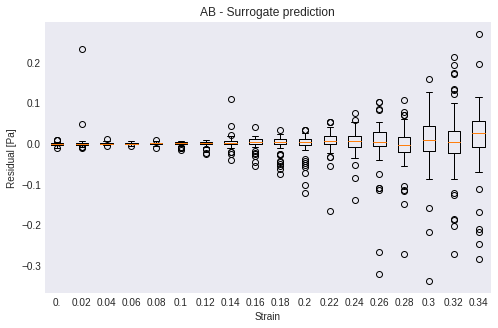

In [66]:
'''
Plotting residuals per strain values 
'''
total_array = []
for strain_value in strain_fe_adventitia:    
    indices = np.where(testX[:, 0] == strain_value)
    total_array.append((testY[indices] - simY[indices]).squeeze())

plt.figure(figsize=(8,5))  
plt.boxplot(total_array)
plt.xticks([1, 2, 3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18], ["0.","0.02", "0.04", "0.06", "0.08", "0.1" , "0.12", "0.14", "0.16",
                                        "0.18", "0.2" ,"0.22", "0.24", "0.26", "0.28", "0.3" , "0.32", "0.34"])

plt.xlabel("Strain")
plt.ylabel("Residual [MPa]")
plt.title("AB - Surrogate prediction")
plt.grid()
plt.show()

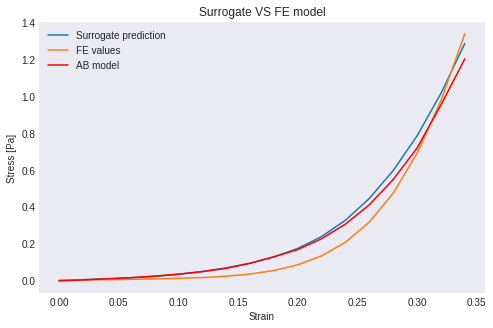

In [70]:
'''
Test in experimental data 
'''

good_coeffs = np.array([0.014,0,0,0,40,175])

## AB model response for good_coeffs 
AB = [-0.00283393,0.00263095,0.00860905,0.0152457,0.0234279,0.0339502,0.0476025,0.0653891,0.0925499,0.128252,0.16718,0.225922,0.305606,0.410193,0.547404,0.718079,0.951887,1.2017]


test_par_set = create_coefficients_set(good_coeffs, strain_fe_adventitia)
simY, simMse = model.predict(test_par_set)

plt.figure(figsize=(8,5))
plt.plot(strain_fe_adventitia, simY,label = "Surrogate prediction")
plt.plot(strain_fe_adventitia, stress_fe_adventitia, label ="FE values" )
plt.plot(strain_fe_adventitia, AB, color = "red", label ="AB model" )
plt.xlabel("Strain")
plt.ylabel("Stress [MPa]")
plt.title("Surrogate VS FE model VS AB")
plt.legend()

plt.grid()
plt.show()

# Sobol Sensitivity Analysis

In [71]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
plt.rcParams.update({'font.size': 13})


## Define SA problem
problem = {
    'num_vars': 6,
    'names': ['c1', 'c2', 'c3', 'c4', 'c5', 'c6'],
    'bounds': [[0, 0.021],
               [0, 0.7951199200000003],
               [0, 2.3385880000000006],
               [0, 6.878200000000002],
               [0, 60.0],
               [0, 262.5]]
            }

## Sample from the parameters bounds 
param_values = saltelli.sample(problem, 2000)

## Collect SA predictions for each strain values separately
YY = []
for st in range(len(strain_fe_adventitia)):  
    Y = np.zeros([param_values.shape[0]])
    for i, par in enumerate(param_values):
        P = np.insert(par,0,strain_fe_adventitia[st])
        Y[i] = model.predict(np.array([P]))[0]
    YY.append(Y)


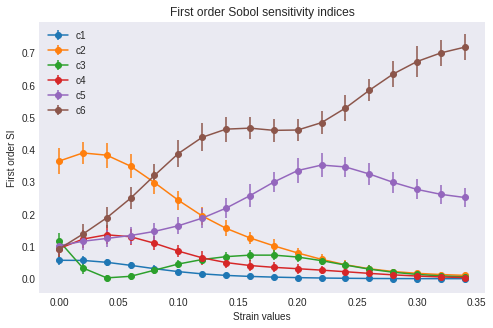

In [73]:
'''
First order Sobol SA
'''

x = strain_fe_adventitia

plt.figure(figsize=(8,5))
for j in range(6):
    y = np.array([sobol.analyze(problem, YY[i])['S1'][j] for i in range(18) ])
    error = np.array([sobol.analyze(problem, YY[i])['S1_conf'][j] for i in range(18) ])
    plt.errorbar(x, y, yerr=error, fmt='-o', label = "c%s"%(j+1))
plt.legend()
plt.xlabel("Strain values")
plt.ylabel("First order SI")
plt.title("First order Sobol sensitivity indices")
plt.grid()
plt.show()


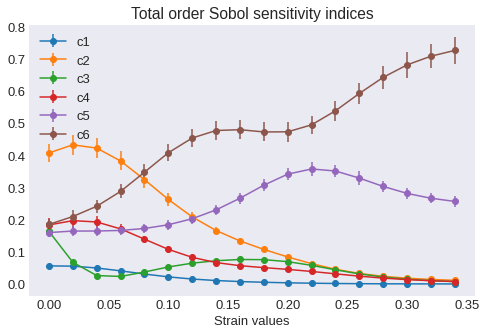

In [75]:
'''
Total order Sobol SA
'''
plt.figure(figsize=(8,5))
for j in range(6):
    y = np.array([sobol.analyze(problem, YY[i])['ST'][j] for i in range(18) ])
    error = np.array([sobol.analyze(problem, YY[i])['ST_conf'][j] for i in range(18) ])
    plt.errorbar(x, y, yerr=error, fmt='-o', label = "c%s"%(j+1))
plt.legend()
plt.xlabel("Strain values")
plt.title("Total order Sobol sensitivity indices")
plt.grid()
plt.show()


# Active Learning

In [170]:

'''
acquisition function for Active Learning
'''

def surrogate(model, X):
    return model.predict(X)


def acquisition_func(X, Xsamples, model):
    # calculate the best surrogate score found so far  (WHY HIGHEST MEAN?)   
    yhat, yhat_std = surrogate(model, X)
    best = max(yhat)
    # calculate mean and stdev via surrogate function
    mu, std = surrogate(model, Xsamples)
    mu = mu[:, 0]
    # Probability of improvement
    probs = norm.cdf((mu - best) / (std[:, 0]+1E-9))
    return probs

# optimize the acquisition function:
def acquisition_optimize(X, par_space, N_samples, model):   # dim = (number of samples x number of parameters)
    # generate random samples 
    Xsamples = sampling_ps_random(par_space, N_samples)
    # calculate the acquisition function for each sample
    scores = acquisition_func(X, Xsamples, model)
    # index of the largest scores
    ix = np.argmax(scores)
    res = np.array(Xsamples[ix]).reshape(1, par_space.shape[1])
    return res, ix

X = parameter_space[new_indices]
y = stress_space[new_indices]

# perform the optimization process
for i in range(500):
    # select the next point to sample
    
    new_x, ind = acquisition_optimize(X, parameter_space, 50 , model)

    # sample the point
    real_new_y = y[ind]
    
    # add the data to the dataset
    X = np.vstack((X, new_x))
    y = np.vstack((y, real_new_y))
    # update the model
    model.optimize(messages=False, max_iters=1000)

In [168]:
'''
Test in unknown data points
'''

new_indices = [ind for ind in np.arange(1800) if ind not in sampled_indices]
testX = parameter_space[new_indices]
testY = stress_space[new_indices]
simY, simMse = model.predict(testX)  # Mean and variance of prediction
rmse = np.sqrt(mse(testY, simY))  # Root mean squared error
print("RMSE: {}".format(rmse))



RMSE: 0.3285978204840542
